In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from game.Bankgames import *
from game.plotting import *
from game.distributions import TruncatedGaussian, Uniform, PiecewiseUniform
import nashpy as nh
from tqdm import tqdm
from utils.project_dirs import *
from game.run_game import run_across_initializations

In [2]:
def plot_mean_sd_over_time(dist_data, labels, title_prefix="Dist to NE"):
    """
    Plots the mean and standard deviation over time for multiple distance metrics.

    Parameters:
    - dist_data: dict {label -> pd.Series} where each series contains numpy arrays of shape (num_experiments, num_rounds)
    - labels: list of str, names for each metric (used in titles and legends)
    - title_prefix: str, prefix for the plot titles
    """
    num_metrics = len(dist_data)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics), sharex=True)

    if num_metrics == 1:
        axes = [axes]  # Ensure it's iterable if only one plot

    for ax, (label, series) in zip(axes, dist_data.items()):

        data = np.array(series.tolist())     # Convert to numpy array (shape: num_experiments x num_rounds)
        # Compute mean and std deviation across experiments
        mean_dist = np.mean(data, axis=0)
        std_dist = np.std(data, axis=0)

        # Time steps
        rounds = np.arange(len(mean_dist))

        # Plot mean with shaded SD region
        ax.plot(rounds, mean_dist, label=f"{label} - Mean", linewidth=2)
        ax.fill_between(rounds, mean_dist - std_dist, mean_dist + std_dist, alpha=0.2, label=f"{label} ± 1 SD")

        # Labels and title
        ax.set_ylabel("L2 Distance")
        ax.set_title(f"{title_prefix} ({label})")
        ax.legend()
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Rounds")  # Only the last subplot gets the x-label
    plt.suptitle(title_prefix, fontsize=14)
    plt.tight_layout()
    plt.show()

## Epsilon_1 > 0, Epsilon_2 >0 (Case ++)

## Single symmetric NE is that both banks have strategy (tau_l, gamma_h)

In [3]:
gammas = sorted([0.1, 0.9])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.1
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.015334892335036654 0.014988490787599265


In [4]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

1

[[[0, 1, 0, 0], [0, 1, 0, 0]]]

1

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.]))]

## Code below runs hedge on all 3 games
- with the known matrix
- with the fresh matrix
- with the moving average matrix

And initializes 5 different random probability vectors for both banks (seed set for reproducibility)

In [5]:
# save directory for dataframe
instance_name = f'Tg_mu{mu}_sig{sigma}_gamma{str(gammas)}.pkl' # truncated gaussian
epsigns = 'sign++'
save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
print(save_path)

/Users/krishna/Documents/Research/BankGame/bankgame/notebooks/../saved_df/2_gamma/sign++/Tg_mu0.1_sig0.2_gamma[0.1, 0.9].pkl


In [6]:
T = 20000
eta = 0.1

df = run_across_initializations(gtm=gtm, save_dest=save_path, num_startprofiles=5, T=T, eta = eta)

100%|█████████████████████████████████████████████| 5/5 [01:00<00:00, 12.18s/it]


In [7]:
df.columns #across 5 different random starting vectors for both banks

Index(['Bank1_start', 'Bank2_start', 'Bank1iter_knownmat',
       'Bank2iter_knownmat', 'closestNE_knownmat', 'closestNEdist_knownmat',
       'closestNEdist_knownmat_b1', 'closestNEdist_knownmat_b2',
       'Bank1iter_fresh1', 'Bank2iter_fresh1', 'closestNE_fresh1',
       'closestNEdist_fresh1', 'closestNEdist_fresh1_b1',
       'closestNEdist_fresh1_b2', 'Bank1iter_moving1', 'Bank2iter_moving1',
       'closestNE_moving1', 'closestNEdist_moving1',
       'closestNEdist_moving1_b1', 'closestNEdist_moving1_b2'],
      dtype='object')

In [8]:
df['closestNE_knownmat'], df['closestNE_fresh1'], df['closestNE_moving1']

(0    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 1    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 1    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 1    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_moving1, dtype: object)

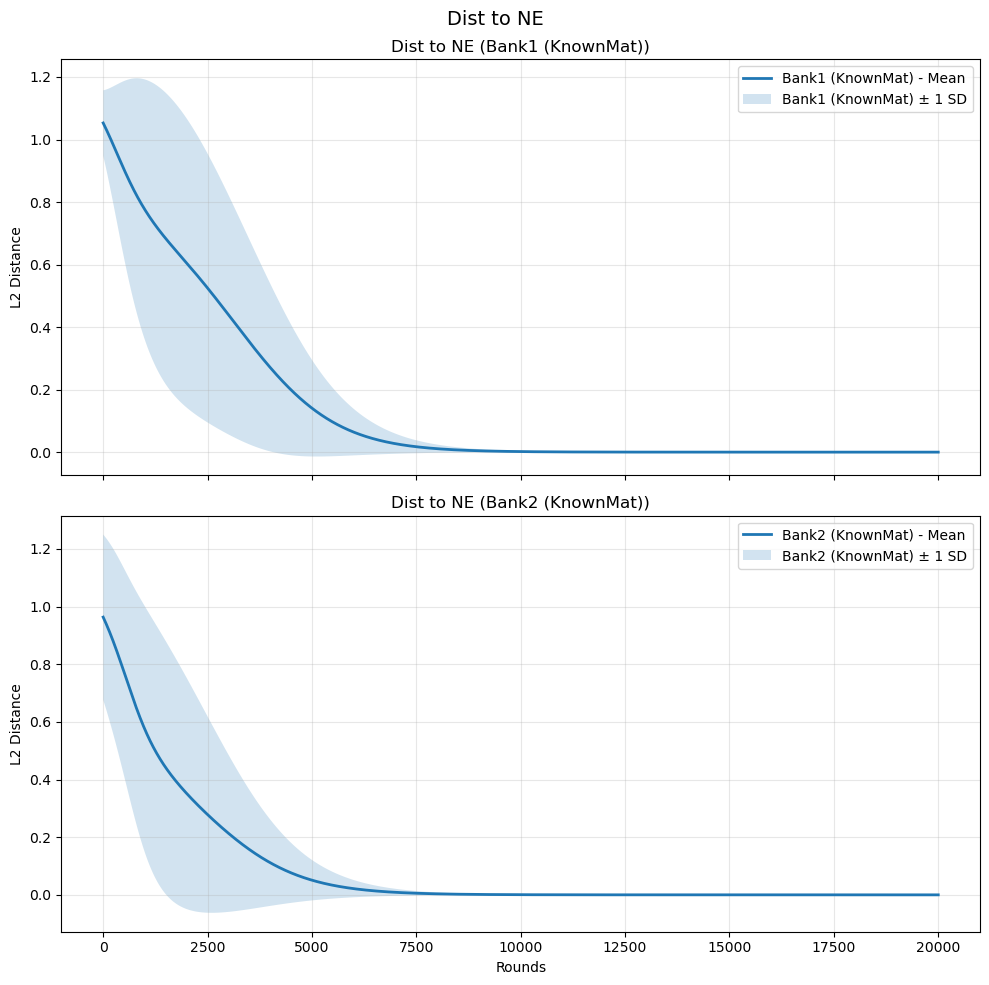

In [9]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (KnownMat)": df['closestNEdist_knownmat_b1'],
        "Bank2 (KnownMat)": df['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"]
)

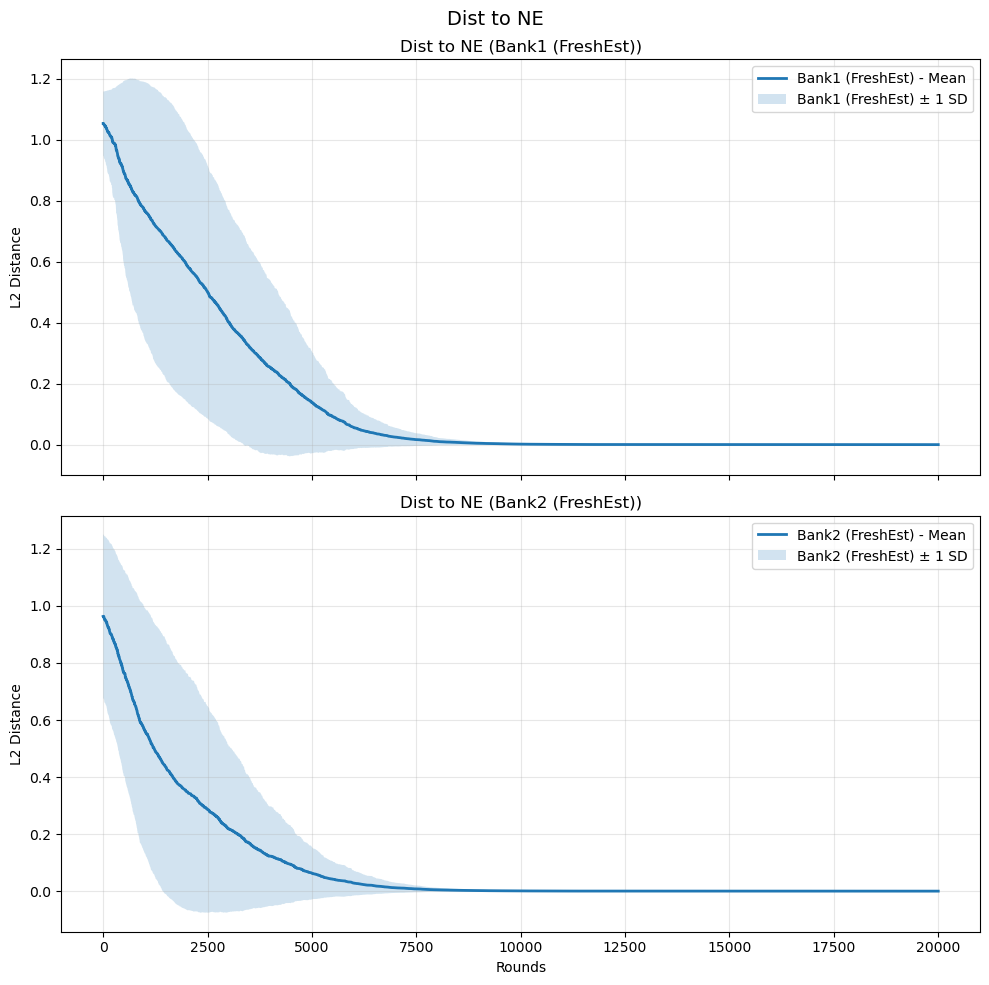

In [10]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (FreshEst)": df['closestNEdist_fresh1_b1'],
        "Bank2 (FreshEst)": df['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"]
)

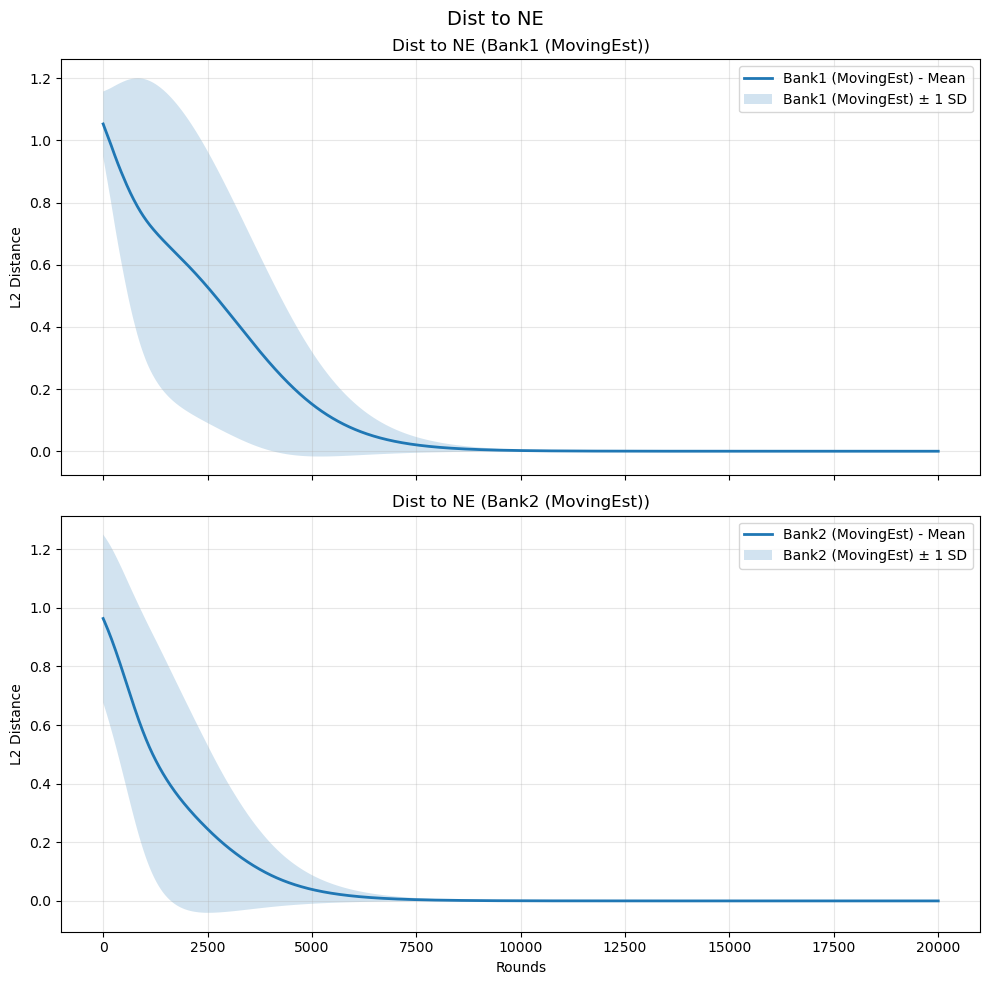

In [11]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (MovingEst)": df['closestNEdist_moving1_b1'],
        "Bank2 (MovingEst)": df['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"]
)

## Epsilon_1 < 0, Epsilon_2 < 0  (Case --)

## Single symmetric NE is that both banks have strategy (tau_h, gamma_l)

In [12]:
gammas = sorted([0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.6
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1<0 and epsilon2<0

-0.12134951137879568 -0.22492712153259348


In [13]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

1

[[[0, 0, 1, 0], [0, 0, 1, 0]]]

1

[(array([0., 0., 1., 0.]), array([0., 0., 1., 0.]))]

In [14]:
# save directory for dataframe
instance_name = f'Tg_mu{mu}_sig{sigma}_gamma{str(gammas)}.pkl' # truncated gaussian
epsigns = 'sign--'
save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
print(save_path)

/Users/krishna/Documents/Research/BankGame/bankgame/notebooks/../saved_df/2_gamma/sign--/Tg_mu0.6_sig0.2_gamma[0.4, 0.8].pkl


In [15]:
T = 20000
eta = 0.1

df = run_across_initializations(gtm=gtm, save_dest=save_path, num_startprofiles=5, T=T, eta = eta)

100%|█████████████████████████████████████████████| 5/5 [00:58<00:00, 11.64s/it]


In [16]:
df['closestNE_knownmat'], df['closestNE_fresh1'], df['closestNE_moving1']

(0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_moving1, dtype: object)

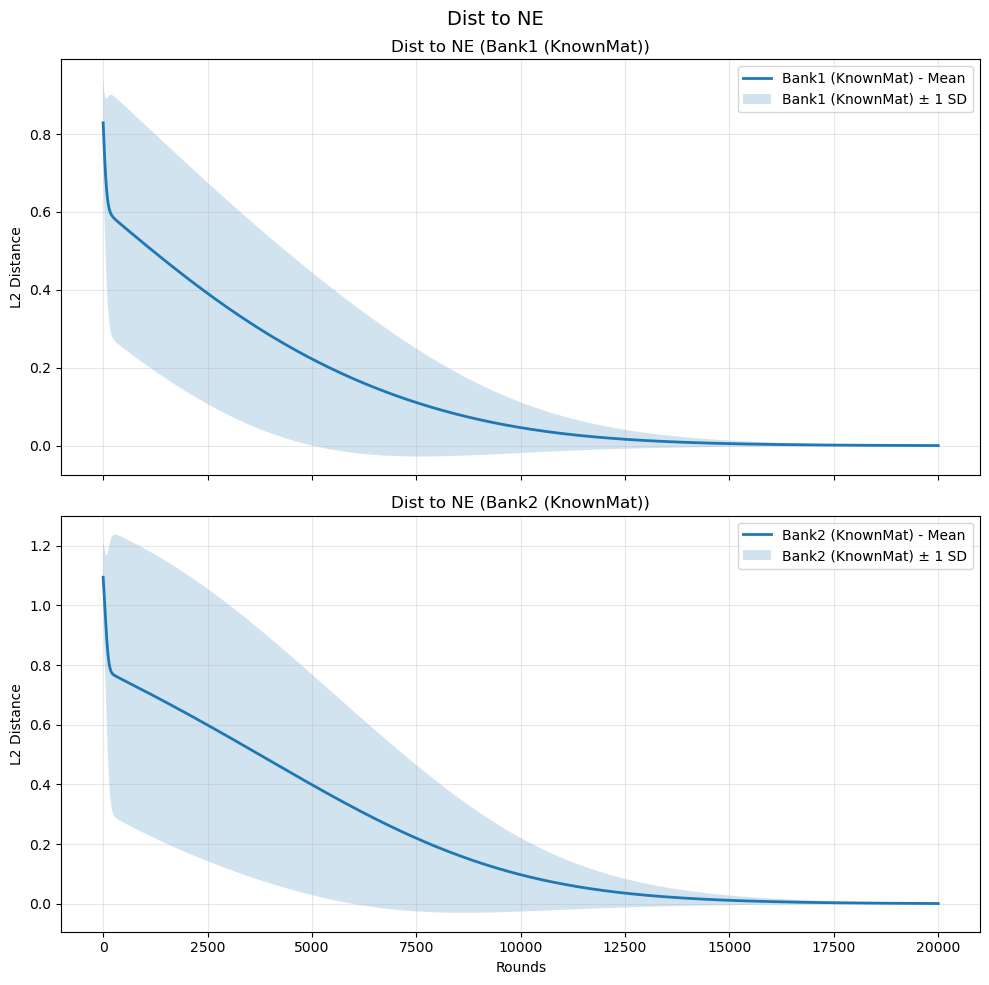

In [17]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (KnownMat)": df['closestNEdist_knownmat_b1'],
        "Bank2 (KnownMat)": df['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"]
)

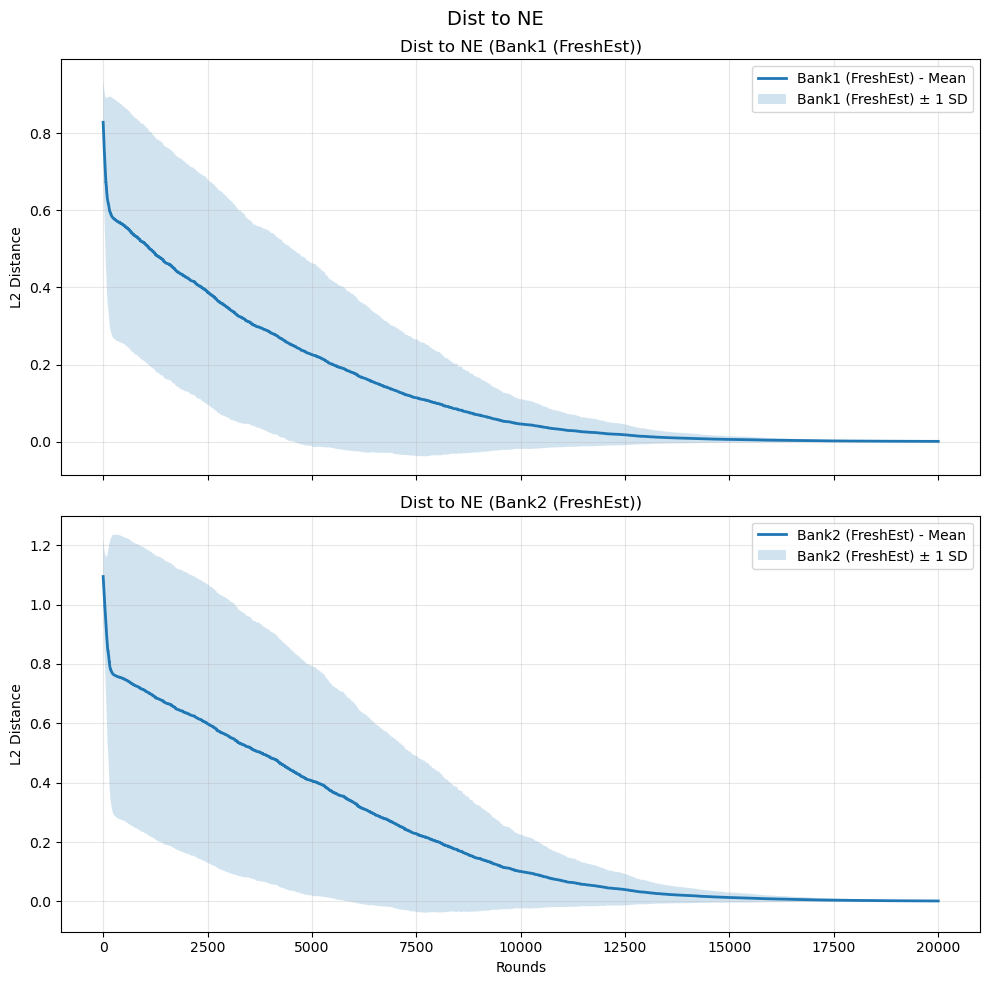

In [18]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (FreshEst)": df['closestNEdist_fresh1_b1'],
        "Bank2 (FreshEst)": df['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"]
)

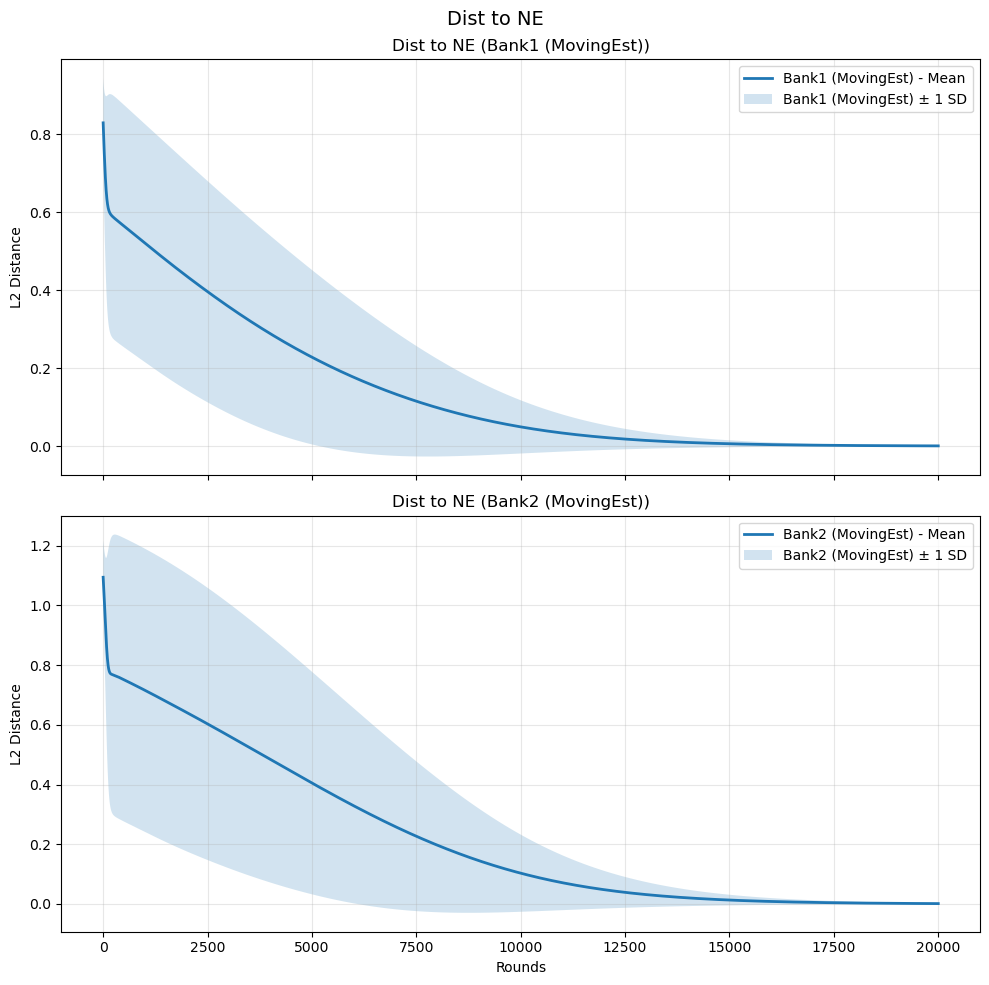

In [19]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (MovingEst)": df['closestNEdist_moving1_b1'],
        "Bank2 (MovingEst)": df['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"]
)

## Epsilon_1 > 0, Epsilon_2 < 0 (Case +-)

## 3 NE for utiltiy matrix
 - 1 pure symmetric both (tau_l, gamma_h)
 - 1 pure symmetric both (tau_h, gamma_l)
 - 1 mixed symmetric ([0,c,1-c,0], [0,c,1-c,0])

In [20]:
gammas = sorted([0.1, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.6
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.03311695444624768 -0.12479184642812025


In [21]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

3

[[[0, 0, 1, 0], [0, 0, 1, 0]],
 [[0, 1, 0, 0], [0, 1, 0, 0]],
 [[0, 0.7902779689107038, 0.2097220310892962, 0],
  [0, 0.7902779689107038, 0.2097220310892962, 0]]]

3

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.])),
 (array([0., 0., 1., 0.]), array([0., 0., 1., 0.])),
 (array([0.        , 0.79027797, 0.20972203, 0.        ]),
  array([0.        , 0.79027797, 0.20972203, 0.        ]))]

In [22]:
# save directory for dataframe
instance_name = f'Tg_mu{mu}_sig{sigma}_gamma{str(gammas)}.pkl' # truncated gaussian
epsigns = 'sign+-'
save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
print(save_path)

/Users/krishna/Documents/Research/BankGame/bankgame/notebooks/../saved_df/2_gamma/sign+-/Tg_mu0.6_sig0.2_gamma[0.1, 0.8].pkl


In [23]:
T = 20000
eta = 0.1

df = run_across_initializations(gtm=gtm, save_dest=save_path, num_startprofiles=5, T=T, eta = eta)

100%|█████████████████████████████████████████████| 5/5 [00:59<00:00, 11.87s/it]


In [24]:
df['closestNE_knownmat'], df['closestNE_fresh1'], df['closestNE_moving1']

(0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_moving1, dtype: object)

## Case+- all 3 converge to symmetric pure NE that too tau_h, gamma_l

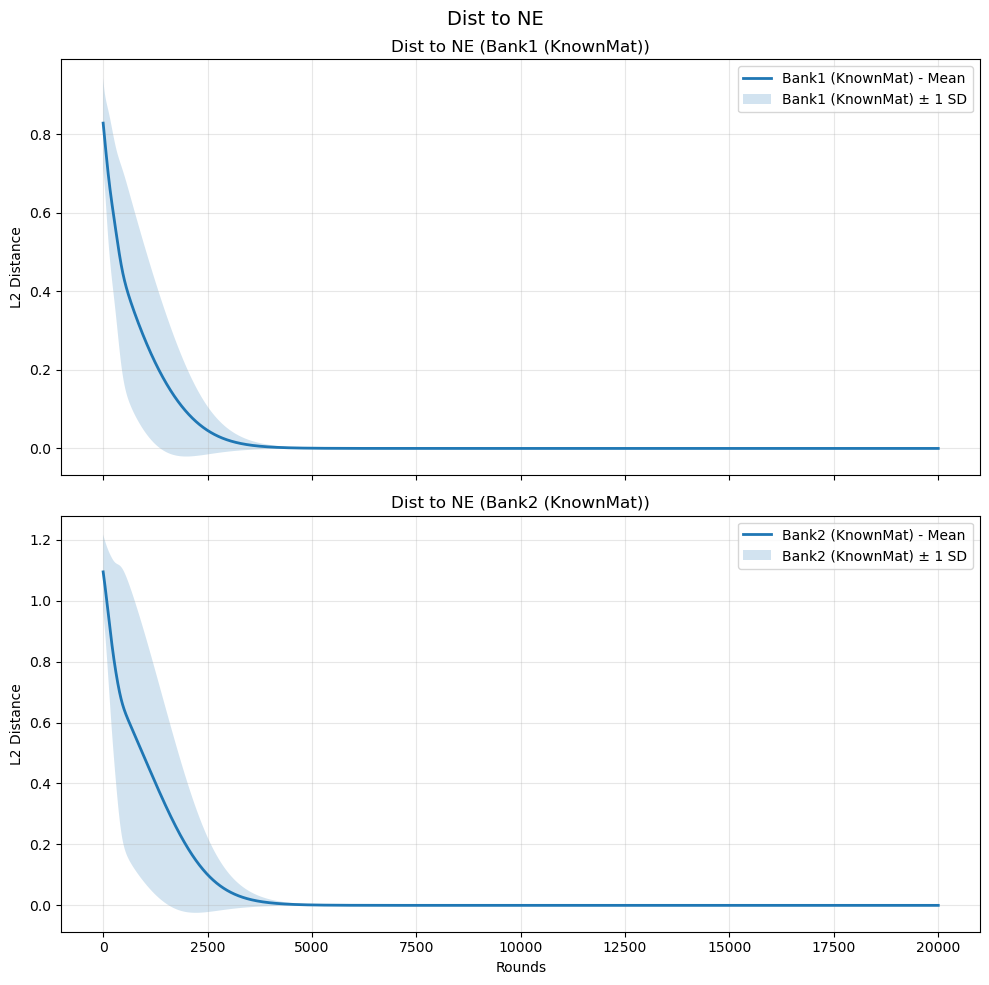

In [25]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (KnownMat)": df['closestNEdist_knownmat_b1'],
        "Bank2 (KnownMat)": df['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"]
)

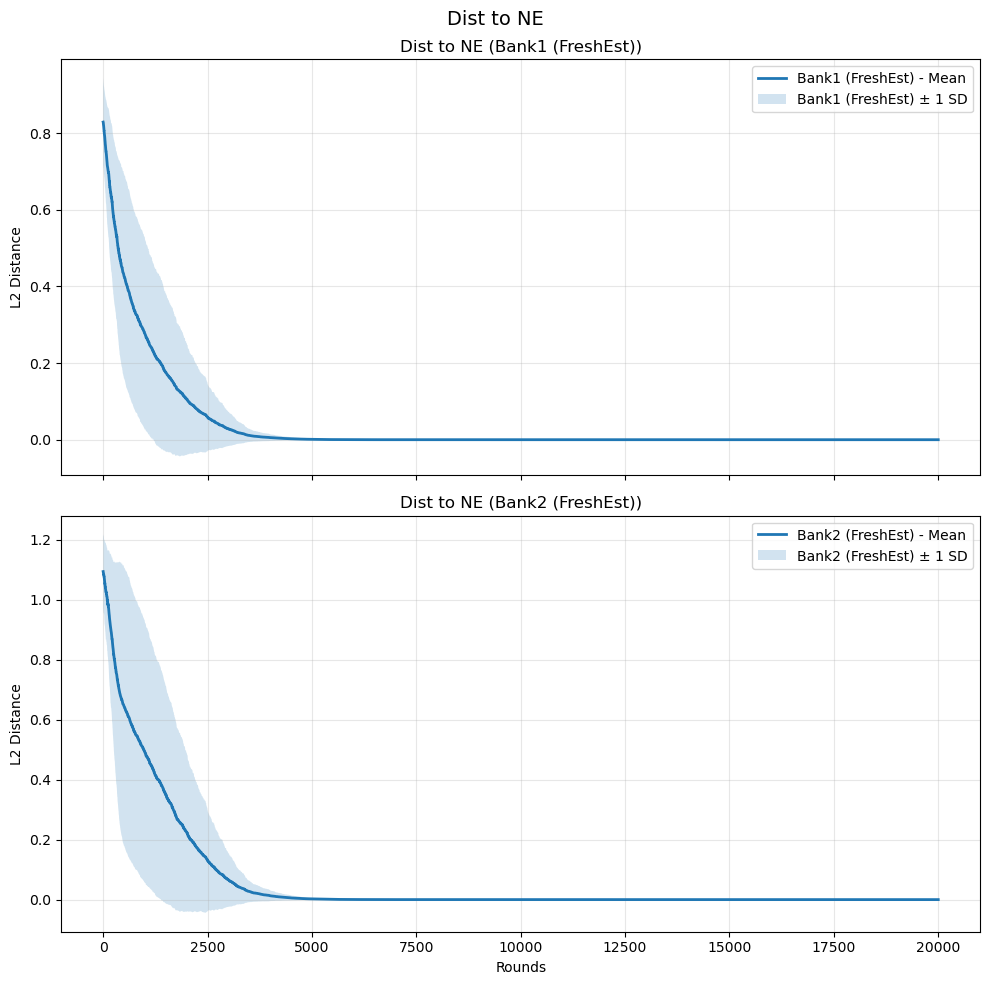

In [26]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (FreshEst)": df['closestNEdist_fresh1_b1'],
        "Bank2 (FreshEst)": df['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"]
)

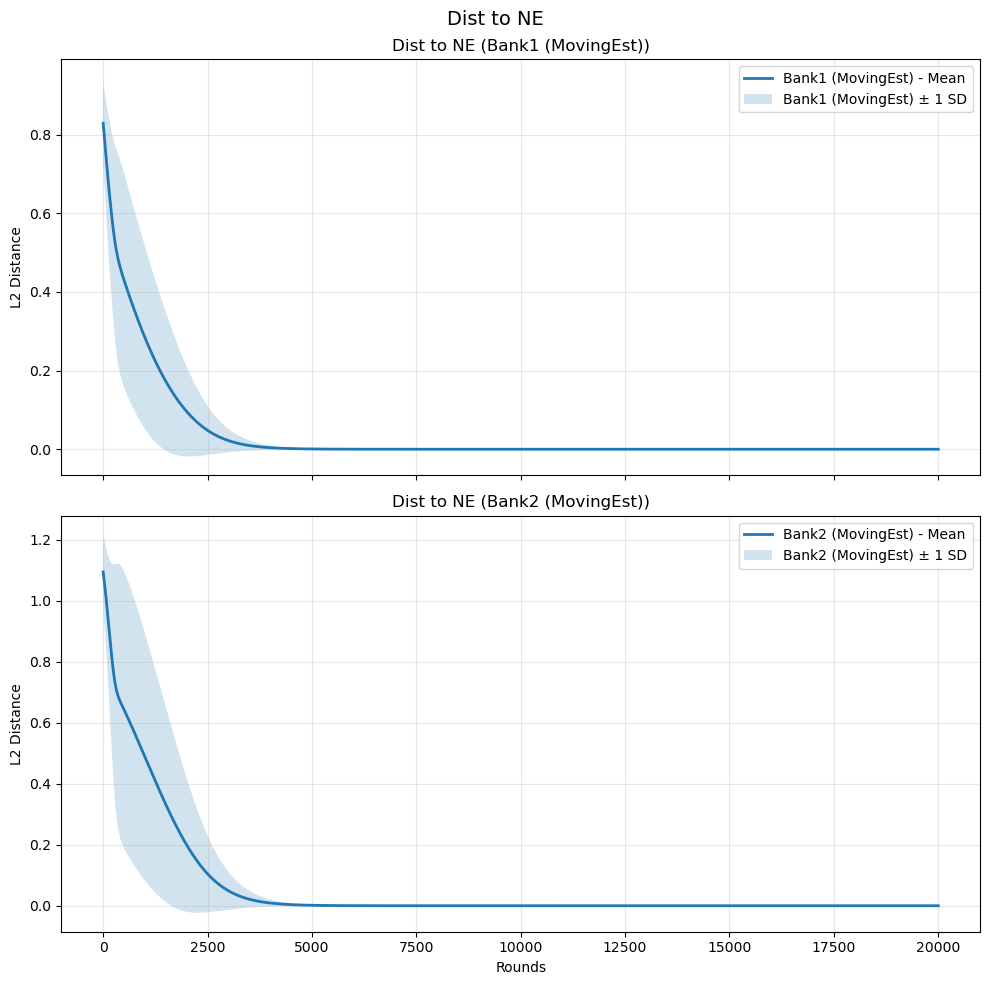

In [27]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (MovingEst)": df['closestNEdist_moving1_b1'],
        "Bank2 (MovingEst)": df['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"]
)

##  eps_1<0 eps_2>0  (Case -+, )

Here is where we needed to use the **piecewise uniform**, because trunc gaussian never resulted in epsilon -+ across parameters

3 NE
-  1 pure asymetric [(tau_l, gamma_h), (tau_h, gamma_l)]
 - 1 pure asymmetric [(tau_h, gamma_l), (tau_l, gamma_h)]
 - 1 mixed symmetric ([0,c,1-c,0], [0,c,1-c,0])

In [28]:
gammas = sorted([0.5, 0.6])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(-0.004100000000000131, 0.004000000000000007)

In [29]:
display(len(gtm.NE_theory), gtm.NE_theory)

display(len(gtm.NE_se), gtm.NE_se)

3

[[[0, 1, 0, 0], [0, 0, 1, 0]],
 [[0, 0, 1, 0], [0, 1, 0, 0]],
 [[0, 0.49382716049382785, 0.5061728395061722, 0],
  [0, 0.49382716049382785, 0.5061728395061722, 0]]]

3

[(array([0., 1., 0., 0.]), array([0., 0., 1., 0.])),
 (array([0., 0., 1., 0.]), array([0., 1., 0., 0.])),
 (array([0.        , 0.49382716, 0.50617284, 0.        ]),
  array([0.        , 0.49382716, 0.50617284, 0.        ]))]

In [30]:
# save directory for dataframe
instance_name = f'Punif_gamma{str(gammas)}.pkl' # truncated gaussian
epsigns = 'sign-+'
save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
print(save_path)

/Users/krishna/Documents/Research/BankGame/bankgame/notebooks/../saved_df/2_gamma/sign-+/Punif_gamma[0.5, 0.6].pkl


In [ ]:
T = 50000
eta = 0.1

df = run_across_initializations(gtm=gtm, save_dest=save_path, num_startprofiles=5, T=T, eta = eta)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [ ]:
df['closestNE_knownmat'], df['closestNE_fresh1'], df['closestNE_moving1'] # Epic, shows different asymmetric based on starting

In [ ]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (KnownMat)": df['closestNEdist_knownmat_b1'],
        "Bank2 (KnownMat)": df['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"]
)

In [ ]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (FreshEst)": df['closestNEdist_fresh1_b1'],
        "Bank2 (FreshEst)": df['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"]
)

In [ ]:
# Example Usage:
plot_mean_sd_over_time(
    {
        "Bank1 (MovingEst)": df['closestNEdist_moving1_b1'],
        "Bank2 (MovingEst)": df['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"]
)